In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec2/train', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec2/test', transform=transform)

In [22]:
print(len(train_dataset))
print(len(test_dataset))

4282
1072


In [23]:
import torch.nn as nn
from torchvision.models import resnet18

# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ResNet18(num_classes=2).to(device)

# Define loss function and optimizer
numSample_list = [1258,4096]
weights = [1 - (x / sum(numSample_list)) for x in numSample_list]
weights = torch.FloatTensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, optimizer, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [24]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []
test_fpr_list = []
test_tpr_list = []

num_initial_samples = 10
batch_size = 2

# Define initial labeled dataset
labeled_indices = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)

unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)]
unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

# Define data loaders
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


step = 1
current_time = time.time()  # current time
end_time = current_time + 3 * 60 * 60  # 3 hours later

# Active learning loop
# Exit while loop either when unlabeled dataset is empty or 3hour spent
while(len(unlabeled_dataset) > 0 and time.time() < end_time):
    print("Step number:", step)
    
    # Train model on labeled dataset
    train_loss, train_acc = train(model, optimizer, labeled_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")    

   # Evaluate model on test dataset
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        test_loss /= len(test_loader)
        test_acc /= total
        test_acc_list.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'binary')
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix")
        print(cm)
        # TN FP
        # FN TP
        test_precision_list.append(precision)
        test_recall_list.append(recall)
        test_f1_list.append(f1)
        print(f"Test Precision: {precision.item():.4f}, Test Recall: {recall.item():.4f}, Test F1 Score: {f1.item():.4f}")
        # Compute AUC score and ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        test_auc_list.append(auc_score)
        test_fpr_list.append(fpr)
        test_tpr_list.append(tpr)
        print(f"AUC Score: {auc_score:.4f}")

    # # Iteration end condition
    # if step == 2:
    #     break
    
    # Make model predictions on unlabeled dataset
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader:
            images = images.to(device)
            output = model(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # Select samples to label using entropy-based method
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    _, idx = torch.topk(entropy, k = 5) # select top 5
        
    labeled_indices = torch.cat([labeled_indices, unlabeled_indices[idx]])
    unlabeled_indices = unlabeled_indices[~torch.eq(unlabeled_indices.unsqueeze(1), unlabeled_indices[idx]).any(1)]

    labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)
    print("Updated Length of labeled dataset : ",len(labeled_dataset))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset))
    print("-----------------------------------------------------------")

    # Update labeled and unlabeled data loaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

    step+=1

Step number: 1
Train Loss: 0.7402, Train Accuracy: 0.4000
Test Loss: 1.2872, Test Accuracy: 0.3414
Confusion Matrix
[[168  84]
 [622 198]]
Test Precision: 0.7021, Test Recall: 0.2415, Test F1 Score: 0.3593
AUC Score: 0.4541
Updated Length of labeled dataset :  15
Length of unlabeled dataset :  4267
-----------------------------------------------------------
Step number: 2
Train Loss: 1.8207, Train Accuracy: 0.6667
Test Loss: 1.4962, Test Accuracy: 0.6073
Confusion Matrix
[[ 84 168]
 [253 567]]
Test Precision: 0.7714, Test Recall: 0.6915, Test F1 Score: 0.7293
AUC Score: 0.5124
Updated Length of labeled dataset :  20
Length of unlabeled dataset :  4262
-----------------------------------------------------------
Step number: 3
Train Loss: 2.3523, Train Accuracy: 0.4500
Test Loss: 1.0895, Test Accuracy: 0.5877
Confusion Matrix
[[ 34 218]
 [224 596]]
Test Precision: 0.7322, Test Recall: 0.7268, Test F1 Score: 0.7295
AUC Score: 0.4309
Updated Length of labeled dataset :  25
Length of unlabe

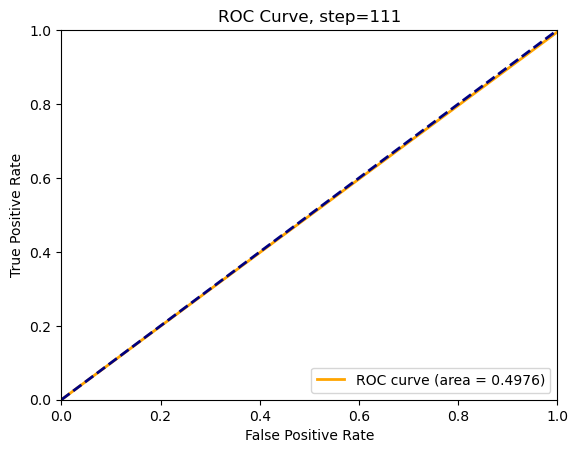

In [25]:
plt.plot(test_fpr_list[-1], test_tpr_list[-1], color='orange', lw=2, label='ROC curve (area = %0.4f)' % auc(test_fpr_list[-1], test_tpr_list[-1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, step={}'.format(step))
plt.legend(loc="lower right")
plt.show()

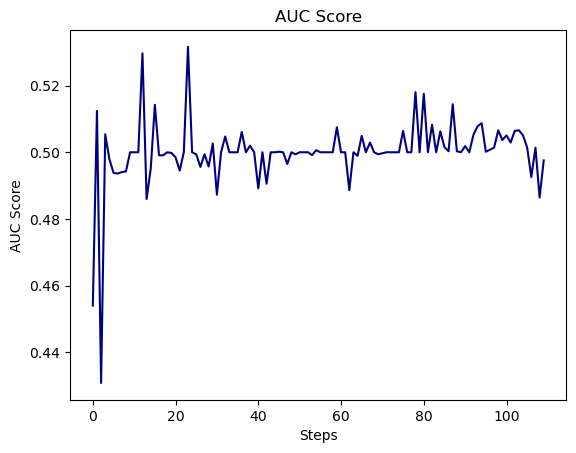

In [27]:
from matplotlib import pyplot as plt

plt.plot(test_auc_list, color = 'navy')
plt.xlabel("Steps")
plt.ylabel("AUC Score")
plt.title('AUC Score')
plt.show()